In [34]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import f1_score
import time
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

sys.path.insert(1, os.path.join(sys.path[0], "code/implementation"))
from layer_v2 import Layer
from neural_network_v2 import NeuralNetwork

In [64]:
def visualize_correctness(layers, activations, initiations , title, nums=7):
    plt.figure(figsize=(14, 10))
    start = 1
    stop = 30  # len(after_epoch_dict["he/relu/1"][0])
    for key, value in after_epoch_dict.items():
        key = key.split("/")
        label = f"{key[1]}, {key[0]}, {key[2]} layers"

        viridis = cm.get_cmap("tab10", nums)
        hash_value = hash(label) % nums
        if key[0] in initiations and key[1] in activations and key[2] in layers:
            plt.plot(
                range(start, stop),
                np.mean(value, axis=0)[start:stop],
                label=label,
                linewidth=4,
                color=viridis(hash_value),
            )

            plt.fill_between(
                range(start, stop),
                np.maximum(np.mean(value, axis=0) - np.std(value, axis=0), 0)[start:stop],
                np.mean(value, axis=0)[start:stop] + np.std(value, axis=0)[start:stop],
                alpha=0.1,
                color=viridis(hash_value),
            )

    plt.legend()
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("MSE")

In [9]:
multimodal_train = pd.read_csv(
    "https://raw.githubusercontent.com/nizwant/miowid/main/data/regression/multimodal-large-training.csv"
)
multimodal_test = pd.read_csv(
    "https://raw.githubusercontent.com/nizwant/miowid/main/data/regression/multimodal-large-test.csv"
)
mean = multimodal_train.mean()
std = multimodal_train.std()
multimodal_train = (multimodal_train - mean) / std
multimodal_test = (multimodal_test - mean) / std

In [10]:
activation_functions = ["relu", "leaky_relu", "sigmoid"]
initialization_methods = [
    "uniform_xavier",
    "he",
]
number_of_repetition = 15  
versions = 2

In [11]:
from collections import defaultdict

df = pd.DataFrame(
    columns=[
        "Initialization",
        "Activation",
        "Hidden Layers",
        "Cost",
        "Computation Time",
        "Version",
    ]
)
after_epoch_dict = defaultdict(lambda: [])

for initialization_method in initialization_methods:
    for activation in activation_functions:
        for _ in range(number_of_repetition):
            for v in range(1, versions + 1):
                # One hidden layer creation
                one_hidden = NeuralNetwork(cost_function="mse")
                one_hidden.add_layer(
                    Layer(1, 10, activation, weight_initialization=initialization_method)
                )
                one_hidden.add_layer(Layer(10, 1, "linear"))

                # Two hidden layers creation
                two_hidden = NeuralNetwork(cost_function="mse")
                two_hidden.add_layer(
                    Layer(1, 10, activation, weight_initialization=initialization_method)
                )
                two_hidden.add_layer(
                    Layer(10, 10, activation, weight_initialization=initialization_method)
                )
                two_hidden.add_layer(Layer(10, 1, "linear"))

                # Three hidden layers creation
                three_hidden = NeuralNetwork(cost_function="mse")
                three_hidden.add_layer(
                    Layer(1, 10, activation, weight_initialization=initialization_method)
                )
                three_hidden.add_layer(
                    Layer(10, 10, activation, weight_initialization=initialization_method)
                )
                three_hidden.add_layer(
                    Layer(10, 10, activation, weight_initialization=initialization_method)
                )
                three_hidden.add_layer(Layer(10, 1, "linear"))

                # Training
                time_start = time.time()
                one_cost_after_epoch = one_hidden.train(
                    multimodal_train["x"],
                    multimodal_train["y"],
                    max_num_epoch=200,
                    learning_rate=0.01,
                    batch_fraction=1,
                )
                time_first = time.time() - time_start
                two_cost_after_epoch = two_hidden.train(
                    multimodal_train["x"],
                    multimodal_train["y"],
                    max_num_epoch=200,
                    learning_rate=0.01,
                    batch_fraction=1,
                )
                time_second = time.time() - time_start - time_first
                three_cost_after_epoch = three_hidden.train(
                    multimodal_train["x"],
                    multimodal_train["y"],
                    max_num_epoch=200,
                    learning_rate=0.01,
                    batch_fraction=1,
                )
                time_third = time.time() - time_start - time_first - time_second

                # Testing
                one_hidden_test_cost = one_hidden.calculate_cost(
                    multimodal_test["x"], multimodal_test["y"]
                )
                two_hidden_test_cost = two_hidden.calculate_cost(
                    multimodal_test["x"], multimodal_test["y"]
                )
                three_hidden_test_cost = three_hidden.calculate_cost(
                    multimodal_test["x"], multimodal_test["y"]
                )

                # Saving cost after training results
                df.loc[len(df.index)] = [
                    initialization_method,
                    activation,
                    "1",
                    one_hidden_test_cost,
                    time_first,
                    v,
                ]
                df.loc[len(df.index)] = [
                    initialization_method,
                    activation,
                    "2",
                    two_hidden_test_cost,
                    time_second,
                    v,
                ]
                df.loc[len(df.index)] = [
                    initialization_method,
                    activation,
                    "3",
                    three_hidden_test_cost,
                    time_third,
                    v,
                ]

                # Saving cost after epoch results
                after_epoch_dict[f"{initialization_method}/{activation}/1/v{v}"].append(
                    one_cost_after_epoch
                )
                after_epoch_dict[f"{initialization_method}/{activation}/2/v{v}"].append(
                    two_cost_after_epoch
                )
                after_epoch_dict[f"{initialization_method}/{activation}/3/v{v}"].append(
                    three_cost_after_epoch
                )


    print(f"Initialization method {initialization_method} done")

Initialization method uniform_xavier done
Initialization method he done
Initialization method normal_xavier done


/var/folders/g0/c58bxqzn6djcv8sqkxtcj8dc0000gn/T/ipykernel_8561/3505606068.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('tab10', 10)


Text(0, 0.5, 'MSE')

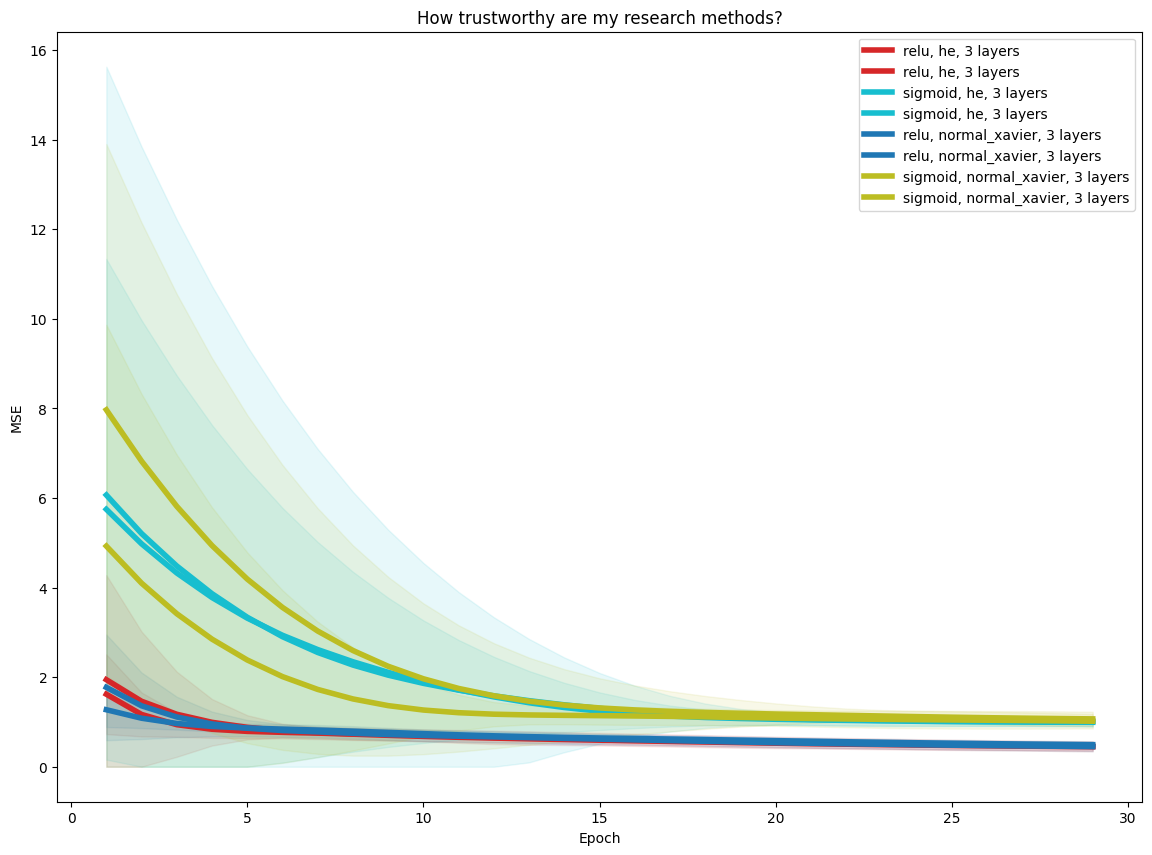

In [43]:
plt.figure(figsize=(14, 10))
start = 1
stop = 30  # len(after_epoch_dict["he/relu/1"][0])
for key, value in after_epoch_dict.items():
    key = key.split("/")
    label = f"{key[1]}, {key[0]}, {key[2]} layers"


    viridis = cm.get_cmap('tab10', 10)
    hash_value = hash(label) % 10
    if (
        key[0] in ["he", "normal_xavier"]
        and key[1] in ["sigmoid" , "relu"]
        and key[2] in ["3"]
    ):
        plt.plot(
            range(start, stop),
            np.mean(value, axis=0)[start:stop],
            label=label,
            linewidth=4,
            color=viridis(hash_value),
        )

        plt.fill_between(
            range(start, stop),
            np.maximum(np.mean(value, axis=0) - np.std(value, axis=0), 0)[start:stop],
            np.mean(value, axis=0)[start:stop] + np.std(value, axis=0)[start:stop],
            alpha=0.1,
            color=viridis(hash_value),
        )

plt.legend()
plt.title(
    "How trustworthy are my research methods?"
)
plt.xlabel("Epoch")
plt.ylabel("MSE")

/var/folders/g0/c58bxqzn6djcv8sqkxtcj8dc0000gn/T/ipykernel_8561/4219309187.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap("tab10", 7)


Text(0, 0.5, 'MSE')

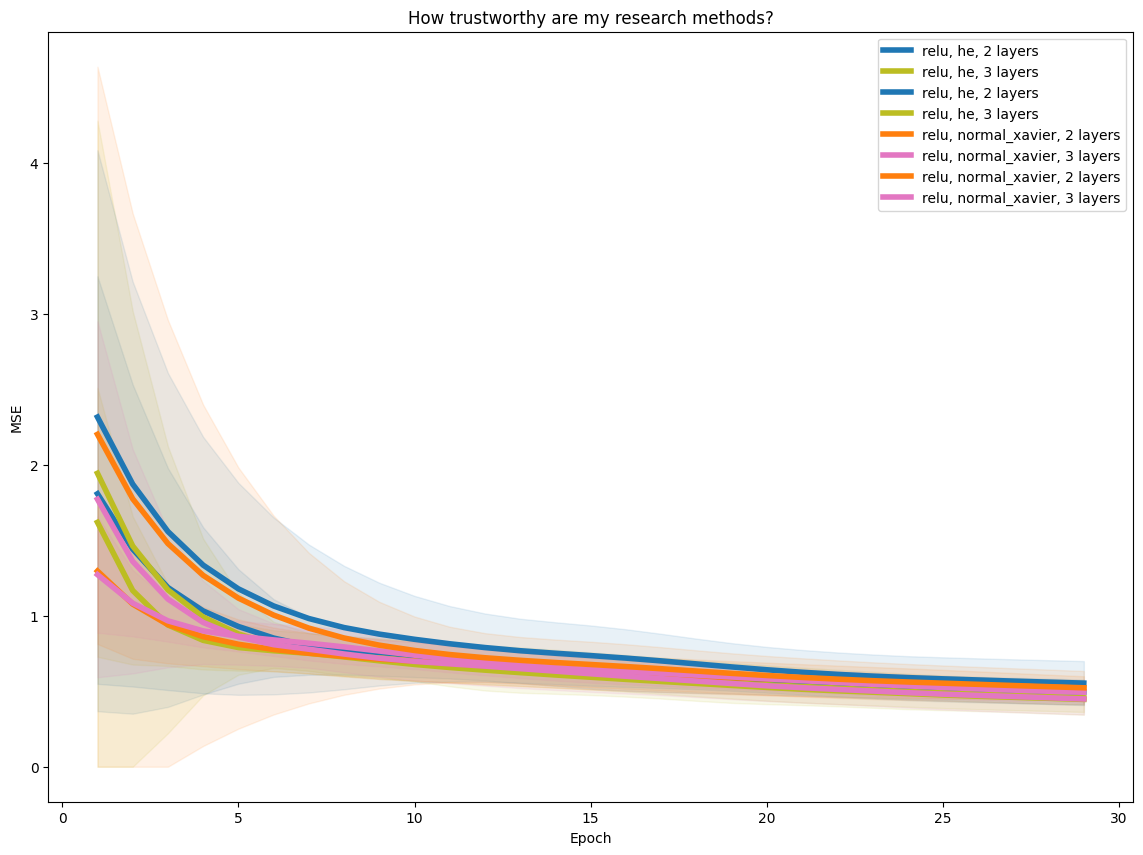

In [47]:
plt.figure(figsize=(14, 10))
start = 1
stop = 30  # len(after_epoch_dict["he/relu/1"][0])
for key, value in after_epoch_dict.items():
    key = key.split("/")
    label = f"{key[1]}, {key[0]}, {key[2]} layers"

    viridis = cm.get_cmap("tab10", 7)
    hash_value = hash(label) % 7
    if (
        key[0] in ["he", "normal_xavier"]
        and key[1] in ["relu"]
        and key[2] in ["3", "2"]
    ):
        plt.plot(
            range(start, stop),
            np.mean(value, axis=0)[start:stop],
            label=label,
            linewidth=4,
            color=viridis(hash_value),
        )

        plt.fill_between(
            range(start, stop),
            np.maximum(np.mean(value, axis=0) - np.std(value, axis=0), 0)[start:stop],
            np.mean(value, axis=0)[start:stop] + np.std(value, axis=0)[start:stop],
            alpha=0.1,
            color=viridis(hash_value),
        )

plt.legend()
plt.title("How trustworthy are my research methods?")
plt.xlabel("Epoch")
plt.ylabel("MSE")

In [48]:
activation_functions = ["relu"]
initialization_methods = [
    "uniform_xavier",
    "he",
]
number_of_repetition = 30
versions = 3

In [49]:
from collections import defaultdict

df = pd.DataFrame(
    columns=[
        "Initialization",
        "Activation",
        "Hidden Layers",
        "Cost",
        "Computation Time",
        "Version",
    ]
)
after_epoch_dict = defaultdict(lambda: [])

for initialization_method in initialization_methods:
    for activation in activation_functions:
        for _ in range(number_of_repetition):
            for v in range(1, versions + 1):
                # One hidden layer creation
                one_hidden = NeuralNetwork(cost_function="mse")
                one_hidden.add_layer(
                    Layer(
                        1, 10, activation, weight_initialization=initialization_method
                    )
                )
                one_hidden.add_layer(Layer(10, 1, "linear"))

                # Two hidden layers creation
                two_hidden = NeuralNetwork(cost_function="mse")
                two_hidden.add_layer(
                    Layer(
                        1, 10, activation, weight_initialization=initialization_method
                    )
                )
                two_hidden.add_layer(
                    Layer(
                        10, 10, activation, weight_initialization=initialization_method
                    )
                )
                two_hidden.add_layer(Layer(10, 1, "linear"))

                # Three hidden layers creation
                three_hidden = NeuralNetwork(cost_function="mse")
                three_hidden.add_layer(
                    Layer(
                        1, 10, activation, weight_initialization=initialization_method
                    )
                )
                three_hidden.add_layer(
                    Layer(
                        10, 10, activation, weight_initialization=initialization_method
                    )
                )
                three_hidden.add_layer(
                    Layer(
                        10, 10, activation, weight_initialization=initialization_method
                    )
                )
                three_hidden.add_layer(Layer(10, 1, "linear"))

                # Training
                time_start = time.time()
                one_cost_after_epoch = one_hidden.train(
                    multimodal_train["x"],
                    multimodal_train["y"],
                    max_num_epoch=200,
                    learning_rate=0.01,
                    batch_fraction=1,
                )
                time_first = time.time() - time_start
                two_cost_after_epoch = two_hidden.train(
                    multimodal_train["x"],
                    multimodal_train["y"],
                    max_num_epoch=200,
                    learning_rate=0.01,
                    batch_fraction=1,
                )
                time_second = time.time() - time_start - time_first
                three_cost_after_epoch = three_hidden.train(
                    multimodal_train["x"],
                    multimodal_train["y"],
                    max_num_epoch=200,
                    learning_rate=0.01,
                    batch_fraction=1,
                )
                time_third = time.time() - time_start - time_first - time_second

                # Testing
                one_hidden_test_cost = one_hidden.calculate_cost(
                    multimodal_test["x"], multimodal_test["y"]
                )
                two_hidden_test_cost = two_hidden.calculate_cost(
                    multimodal_test["x"], multimodal_test["y"]
                )
                three_hidden_test_cost = three_hidden.calculate_cost(
                    multimodal_test["x"], multimodal_test["y"]
                )

                # Saving cost after training results
                df.loc[len(df.index)] = [
                    initialization_method,
                    activation,
                    "1",
                    one_hidden_test_cost,
                    time_first,
                    v,
                ]
                df.loc[len(df.index)] = [
                    initialization_method,
                    activation,
                    "2",
                    two_hidden_test_cost,
                    time_second,
                    v,
                ]
                df.loc[len(df.index)] = [
                    initialization_method,
                    activation,
                    "3",
                    three_hidden_test_cost,
                    time_third,
                    v,
                ]

                # Saving cost after epoch results
                after_epoch_dict[f"{initialization_method}/{activation}/1/v{v}"].append(
                    one_cost_after_epoch
                )
                after_epoch_dict[f"{initialization_method}/{activation}/2/v{v}"].append(
                    two_cost_after_epoch
                )
                after_epoch_dict[f"{initialization_method}/{activation}/3/v{v}"].append(
                    three_cost_after_epoch
                )

    print(f"Initialization method {initialization_method} done")

Initialization method uniform_xavier done
Initialization method he done


# 30 runs for each of 3 repetition

/var/folders/g0/c58bxqzn6djcv8sqkxtcj8dc0000gn/T/ipykernel_8561/1248088203.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap("tab10", 7)


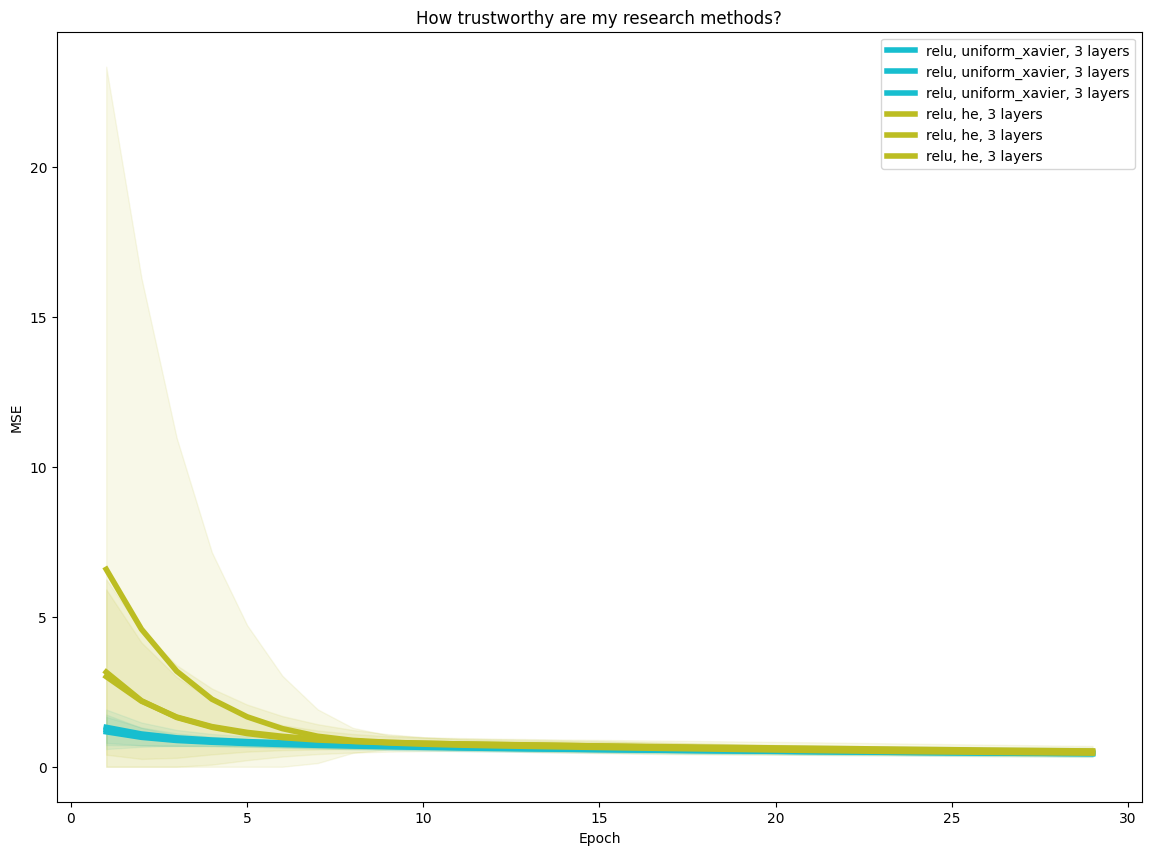

In [60]:
visualize_correctness(
    ["3"],
    ["relu"],
    ["he", "uniform_xavier"],
    "How trustworthy are my research methods?",
)

/var/folders/g0/c58bxqzn6djcv8sqkxtcj8dc0000gn/T/ipykernel_8561/1248088203.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap("tab10", 7)


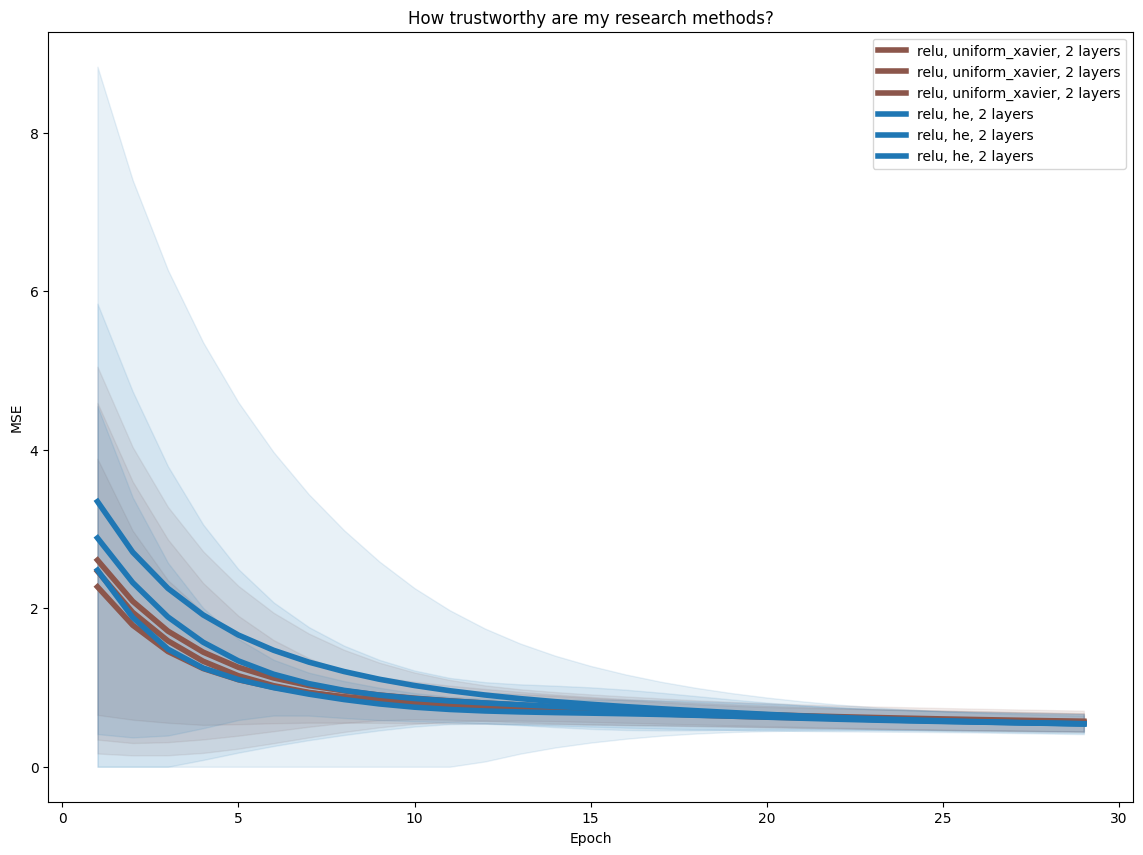

In [61]:
visualize_correctness(
    ["2"],
    ["relu"],
    ["he", "uniform_xavier"],
    "How trustworthy are my research methods?",
)

/var/folders/g0/c58bxqzn6djcv8sqkxtcj8dc0000gn/T/ipykernel_8561/1248088203.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap("tab10", 7)


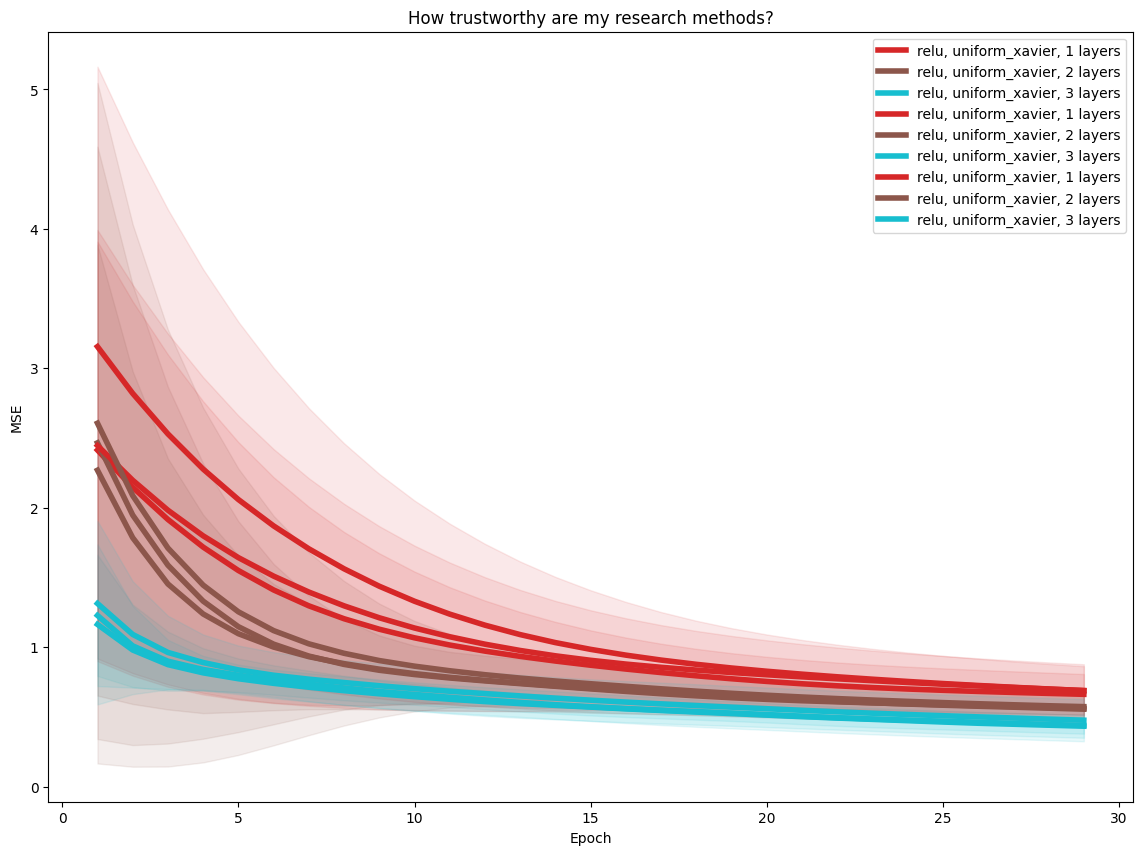

In [62]:
visualize_correctness(
    ["3", "2", "1"],
    ["relu"],
    ["uniform_xavier"],
    "How trustworthy are my research methods?",
)

/var/folders/g0/c58bxqzn6djcv8sqkxtcj8dc0000gn/T/ipykernel_8561/2053561080.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap("tab10", nums)


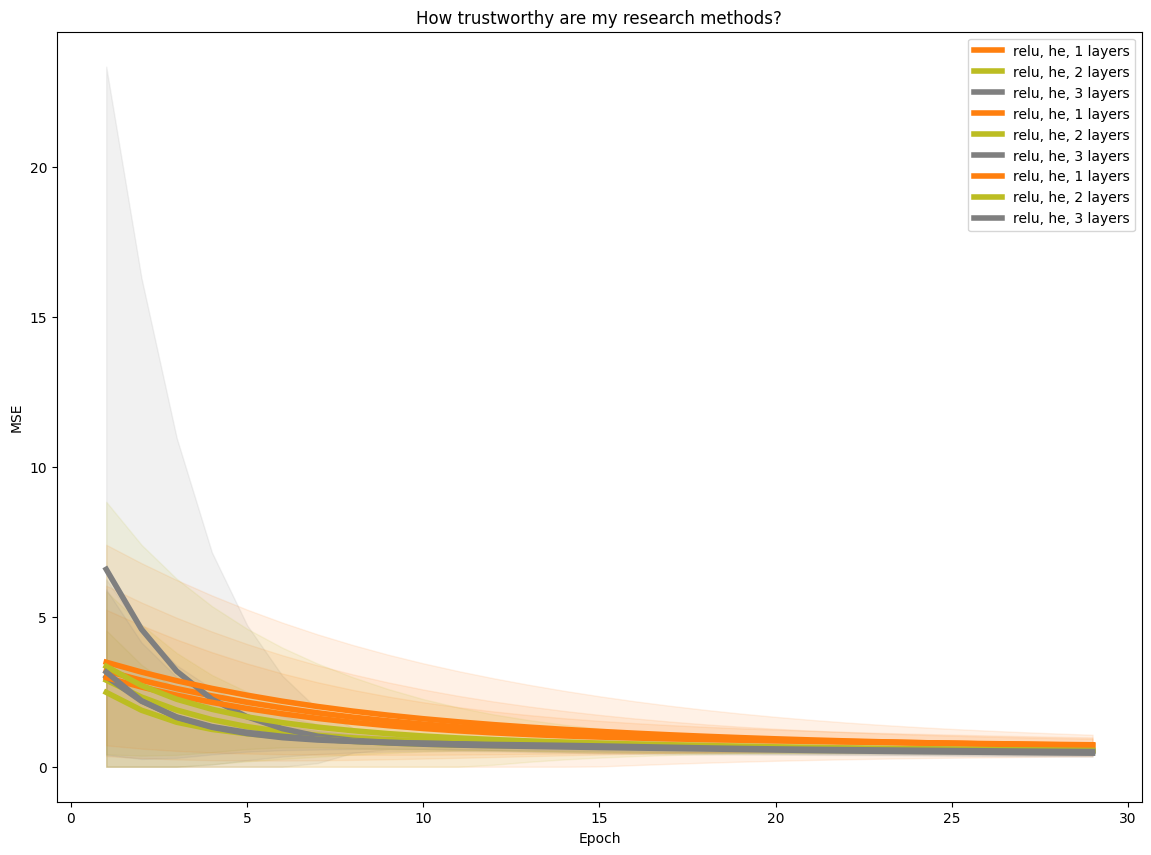

In [66]:
visualize_correctness(
    ["3", "2", "1"],
    ["relu"],
    ["he"],
    "How trustworthy are my research methods?",
    nums =9
)